In [ ]:
%%writefile matmul.cu

#include <stdio.h>
#include <stdlib.h>
#include <cstdio>
#include <cuda_runtime.h>
#include <chrono>
#include <cstring> // For memset, required for clearing result array

#define CHECK(call) do {                                 \
    cudaError_t err = (call);                            \
    if (err != cudaSuccess) {                            \
        std::fprintf(stderr, "CUDA error: %s (%s:%d)\n", \
                     cudaGetErrorString(err), __FILE__, __LINE__); \
        std::exit(1);                                    \
    }                                                    \
} while (0)

/* Original Matrix multiplication kernel: C[row,col] = sum(A[row,k] * B[k,col]) */
__global__ void matrixMul(const int *A, const int *B, int *C,
                         int Arows, int Acols, int Bcols) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < Arows && col < Bcols) {
        int sum = 0;
        for (int k = 0; k < Acols; k++) {
            sum += A[row * Acols + k] * B[k * Bcols + col];
        }
        C[row * Bcols + col] = sum;
    }
}

/* Tiled Matrix multiplication kernel: C[row,col] = sum(A[row,k] * B[k,col]) */
__global__ void tiled_gemm(const int *A, const int *B, int *C,
                           int Arows, int Acols, int Bcols,
                           int tileX, int tileY) {

    extern __shared__ int shared_mem[];
    int TILE_SIZE = tileY;
    int TILE_SQ = TILE_SIZE * TILE_SIZE;

    // Set up pointers for A and B tiles within the single shared memory block
    int *sA = shared_mem;
    int *sB = &shared_mem[TILE_SQ];

    // C matrix index calculation
    int block_row = blockIdx.y * TILE_SIZE;
    int block_col = blockIdx.x * TILE_SIZE;

    int row = block_row + threadIdx.y;
    int col = block_col + threadIdx.x;

    int sum = 0;

    int steps = (Acols + TILE_SIZE - 1) / TILE_SIZE;

    for (int k_tile = 0; k_tile < steps; ++k_tile) {
        // 1. Calculate Global and Shared Indices
        // Global coordinates for the elements this thread loads:
        // A: row is fixed by thread block, column steps through K (Acols)
        int global_row_A = row;
        int global_col_A = k_tile * TILE_SIZE + threadIdx.x; // K dimension for A

        // B: row steps through K (Brows), column is fixed by thread block
        int global_row_B = k_tile * TILE_SIZE + threadIdx.y; // K dimension for B (Brows)
        int global_col_B = col;

        // Shared memory index for this thread: 1D mapping of (threadIdx.y, threadIdx.x)
        int shared_idx = threadIdx.y * TILE_SIZE + threadIdx.x;

        // 2. Load A and B tiles into Shared Memory with Boundary Check
        // Load A tile: A[global_row_A, global_col_A] -> sA[shared_idx]
        if (global_row_A < Arows && global_col_A < Acols) {
            sA[shared_idx] = A[global_row_A * Acols + global_col_A];
        } else {
            // Pad with zero if out of bounds
            sA[shared_idx] = 0;
        }

        // Load B tile: B[global_row_B, global_col_B] -> sB[shared_idx]
        // Note: global_row_B must be checked against Acols (which equals Brows)
        if (global_row_B < Acols && global_col_B < Bcols) {
            sB[shared_idx] = B[global_row_B * Bcols + global_col_B];
        } else {
            // Pad with zero if out of bounds
            sB[shared_idx] = 0;
        }

        // Wait for all threads in the block to finish loading shared memory
        __syncthreads();

        // 3. Compute partial matrix multiplication (Shared Memory Access)
        for (int k = 0; k < TILE_SIZE; ++k) {
            // sA[threadIdx.y, k] * sB[k, threadIdx.x]
            sum += sA[threadIdx.y * TILE_SIZE + k] * sB[k * TILE_SIZE + threadIdx.x];
        }

        // Wait for all threads to finish computation before loading the next tile
        __syncthreads();
    }

    // 4. Write final result to global memory
    if (row < Arows && col < Bcols) {
        C[row * Bcols + col] = sum;
    }
}

// Function to verify and report results for a given kernel
long long verifyAndReport(const int* h_C, const int* h_ref, int Arows, int Bcols, const char* kernel_name) {
    long long mismatches = 0;
    int total_elements = Arows * Bcols;

    // Check up to a maximum of 10 mismatches
    for (int i = 0; i < total_elements; ++i) {
        if (h_C[i] != h_ref[i]) {
            ++mismatches;
            if (mismatches <= 10) {
                fprintf(stdout, "[%s] Mismatch at index %d: gpu=%d cpu=%d\n", kernel_name, i, h_C[i], h_ref[i]);
            }
        }
    }

    if (mismatches == 0) {
        fprintf(stdout, "[%s] All %d results match. OK\n", kernel_name, total_elements);
    } else {
        fprintf(stdout, "[%s] Found %lld mismatches out of %d\n", kernel_name, mismatches, total_elements);
    }
    return mismatches;
}


int main(int argc, char **argv) {
    // --- START of Main function ---
    if (argc <= 1 || (argc == 2 && strcmp(argv[1], "--help") == 0)) {
        printf("Usage:\n");
        printf("  Square matrices:   %s N\n", argv[0]);
        printf("  Custom dimensions: %s Arows Acols Brows Bcols\n", argv[0]);
        printf("Examples:\n");
        printf("  %s 1024          # multiply 1024x1024 matrices\n", argv[0]);
        printf("  %s 128 256 256 32 # multiply A(128x256) * B(256x32)\n", argv[0]);
        return 0;
    }

    // Parse dimensions
    int Arows = 0, Acols = 0, Brows = 0, Bcols = 0;

    if (argc >= 5) {
        Arows = atoi(argv[1]);
        Acols = atoi(argv[2]);
        Brows = atoi(argv[3]);
        Bcols = atoi(argv[4]);
        if (Arows <= 0 || Acols <= 0 || Brows <= 0 || Bcols <= 0) {
            fprintf(stderr, "Invalid dimensions provided. All must be positive integers.\n");
            return 1;
        }
    } else {
        Arows = Acols = Brows = Bcols = atoi(argv[1]);
        if (Arows <= 0) {
            fprintf(stderr, "Invalid size N provided. Must be a positive integer.\n");
            return 1;
        }
    }

    // Validate dimensions for matrix multiplication
    if (Acols != Brows) {
        fprintf(stderr, "Invalid matrix dimensions for multiplication: ");
        fprintf(stderr, "Matrix A columns (%d) must equal Matrix B rows (%d)\n", Acols, Brows);
        return 1;
    }

    // Calculate memory sizes
    size_t bytes_A = (size_t)Arows * (size_t)Acols * sizeof(int);
    size_t bytes_B = (size_t)Brows * (size_t)Bcols * sizeof(int);
    size_t bytes_C = (size_t)Arows * (size_t)Bcols * sizeof(int);

    // Allocate host memory
    int *h_A = (int*)malloc(bytes_A);
    int *h_B = (int*)malloc(bytes_B);
    int *h_C = (int*)malloc(bytes_C);
    int *h_C_tiled = (int*)malloc(bytes_C); // Separate result array for tiled kernel
    if (!h_A || !h_B || !h_C || !h_C_tiled) {
        fprintf(stderr, "Host malloc failed\n");
        return 1;
    }

    // Initialize input matrices with simple pattern
    for (int i = 0; i < Arows; ++i) {
        for (int j = 0; j < Acols; ++j) {
            h_A[i * Acols + j] = i + j;
        }
    }
    for (int i = 0; i < Brows; ++i) {
        for (int j = 0; j < Bcols; ++j) {
            h_B[i * Bcols + j] = i - j;
        }
    }

    // Allocate device memory
    int *d_A = nullptr, *d_B = nullptr, *d_C = nullptr;
    CHECK(cudaMalloc((void **)&d_A, bytes_A));
    CHECK(cudaMalloc((void **)&d_B, bytes_B));
    CHECK(cudaMalloc((void **)&d_C, bytes_C));

    // Copy input matrices from host to device
    CHECK(cudaMemcpy(d_A, h_A, bytes_A, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_B, h_B, bytes_B, cudaMemcpyHostToDevice));

    // --- END of Main function ---

    // 1. CPU Reference Calculation (Only needs to be done once)
    int *h_ref = (int*)malloc(bytes_C);
    if (!h_ref) {
        fprintf(stderr, "Host malloc for reference failed\n");
        return 1;
    }

    auto cpu_start = std::chrono::high_resolution_clock::now();
    for (int i = 0; i < Arows; ++i) {
        for (int j = 0; j < Bcols; ++j) {
            int sum = 0;
            for (int k = 0; k < Acols; ++k) {
                sum += h_A[i * Acols + k] * h_B[k * Bcols + j];
            }
            h_ref[i * Bcols + j] = sum;
        }
    }
    auto cpu_end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> cpu_d = cpu_end - cpu_start;
    double cpu_s = cpu_d.count();
    printf("\n--- Timing and Verification ---\n");
    printf("CPU reference time: %.3f ms\n", cpu_s * 1000.0);

    cudaEvent_t start_evt, stop_evt;
    CHECK(cudaEventCreate(&start_evt));
    CHECK(cudaEventCreate(&stop_evt));

    // 2. Launching the Non-Tiled Kernel (matrixMul)

    // Standard block dimensions (16x16=256 threads)
    dim3 matrixMul_threads(16, 16);
    dim3 matrixMul_blocks(
        (Bcols + matrixMul_threads.x - 1) / matrixMul_threads.x,
        (Arows + matrixMul_threads.y - 1) / matrixMul_threads.y
    );

    printf("\n--- Kernel: gemm (Non-Tiled) ---\n");
    printf("Block: %d x %d threads, Grid: %d x %d blocks\n",
           matrixMul_threads.x, matrixMul_threads.y,
           matrixMul_blocks.x, matrixMul_blocks.y);

    CHECK(cudaMemset(d_C, 0, bytes_C)); // Clear device memory before launch
    CHECK(cudaEventRecord(start_evt, 0));
    matrixMul<<<matrixMul_blocks, matrixMul_threads>>>(d_A, d_B, d_C, Arows, Acols, Bcols);
    CHECK(cudaGetLastError());
    CHECK(cudaEventRecord(stop_evt, 0));
    CHECK(cudaEventSynchronize(stop_evt));

    float matrixMul_ms = 0.0f;
    CHECK(cudaEventElapsedTime(&matrixMul_ms, start_evt, stop_evt));

    // Copy result back to host (h_C is reused for verification)
    CHECK(cudaMemcpy(h_C, d_C, bytes_C, cudaMemcpyDeviceToHost));
    verifyAndReport(h_C, h_ref, Arows, Bcols, "gemm (Non-Tiled)");
    printf("Kernel Time: %.3f ms\n", matrixMul_ms);


    // 3. Launching the Tiled Kernel (tiled_gemm) with Tile Size Sweep
    const int tile_sizes[] = {8, 16, 32};

    for (int i = 0; i < 3; ++i) {
        int TILE_SIZE = tile_sizes[i];

        dim3 tiled_threads(TILE_SIZE, TILE_SIZE);
        dim3 tiled_blocks(
            (Bcols + tiled_threads.x - 1) / tiled_threads.x,
            (Arows + tiled_threads.y - 1) / tiled_threads.y
        );

        printf("\n--- Kernel: tiled_gemm (Tile %dx%d) ---\n", TILE_SIZE, TILE_SIZE);
        printf("Block: %d x %d threads, Grid: %d x %d blocks\n",
               tiled_threads.x, tiled_threads.y,
               tiled_blocks.x, tiled_blocks.y);

        CHECK(cudaMemset(d_C, 0, bytes_C)); // Clear device memory before launch
        CHECK(cudaEventRecord(start_evt, 0));

        tiled_gemm<<<tiled_blocks, tiled_threads, TILE_SIZE * TILE_SIZE * 2 * sizeof(int)>>>(
            d_A, d_B, d_C, Arows, Acols, Bcols, TILE_SIZE, TILE_SIZE);

        CHECK(cudaGetLastError());
        CHECK(cudaEventRecord(stop_evt, 0));
        CHECK(cudaEventSynchronize(stop_evt));

        float tiled_ms = 0.0f;
        CHECK(cudaEventElapsedTime(&tiled_ms, start_evt, stop_evt));

        // Copy result back to host (using the separate h_C_tiled array)
        CHECK(cudaMemcpy(h_C_tiled, d_C, bytes_C, cudaMemcpyDeviceToHost));
        verifyAndReport(h_C_tiled, h_ref, Arows, Bcols, "tiled_gemm");
        printf("Kernel Time: %.3f ms\n", tiled_ms);
    }

    // Cleanup
    free(h_ref);
    free(h_A);
    free(h_B);
    free(h_C);
    free(h_C_tiled);
    CHECK(cudaFree(d_A));
    CHECK(cudaFree(d_B));
    CHECK(cudaFree(d_C));
    CHECK(cudaEventDestroy(start_evt));
    CHECK(cudaEventDestroy(stop_evt));

    return 0; // Returning 0 for clean exit
}

Writing matmul.cu


In [ ]:
!nvcc -arch=sm_75 matmul.cu -o matmul

In [ ]:
!ncu ./matmul 513 8192 8192 1023

==PROF== Connected to process 1001 (/content/matmul)

--- Timing and Verification ---
CPU reference time: 60989.345 ms

--- Kernel: gemm (Non-Tiled) ---
Block: 16 x 16 threads, Grid: 64 x 33 blocks
==PROF== Profiling "matrixMul" - 0: 0%....50%....100% - 9 passes
[gemm (Non-Tiled)] All 524799 results match. OK
Kernel Time: 913.094 ms

--- Kernel: tiled_gemm (Tile 8x8) ---
Block: 8 x 8 threads, Grid: 128 x 65 blocks
==PROF== Profiling "tiled_gemm" - 1: 0%....50%....100% - 9 passes
[tiled_gemm] All 524799 results match. OK
Kernel Time: 536.844 ms

--- Kernel: tiled_gemm (Tile 16x16) ---
Block: 16 x 16 threads, Grid: 64 x 33 blocks
==PROF== Profiling "tiled_gemm" - 2: 0%....50%....100% - 9 passes
[tiled_gemm] All 524799 results match. OK
Kernel Time: 404.734 ms

--- Kernel: tiled_gemm (Tile 32x32) ---
Block: 32 x 32 threads, Grid: 32 x 17 blocks
==PROF== Profiling "tiled_gemm" - 3: 0%....50%....100% - 9 passes
[tiled_gemm] All 524799 results match. OK
Kernel Time: 408.135 ms
==PROF== Disco

In [ ]:
!ncu ./matmul 1024 1024 1024 1024

==PROF== Connected to process 1343 (/content/matmul)

--- Timing and Verification ---
CPU reference time: 13629.000 ms

--- Kernel: gemm (Non-Tiled) ---
Block: 16 x 16 threads, Grid: 64 x 64 blocks
==PROF== Profiling "matrixMul" - 0: 0%....50%....100% - 9 passes
[gemm (Non-Tiled)] All 1048576 results match. OK
Kernel Time: 402.118 ms

--- Kernel: tiled_gemm (Tile 8x8) ---
Block: 8 x 8 threads, Grid: 128 x 128 blocks
==PROF== Profiling "tiled_gemm" - 1: 0%....50%....100% - 9 passes
[tiled_gemm] All 1048576 results match. OK
Kernel Time: 239.980 ms

--- Kernel: tiled_gemm (Tile 16x16) ---
Block: 16 x 16 threads, Grid: 64 x 64 blocks
==PROF== Profiling "tiled_gemm" - 2: 0%....50%....100% - 9 passes
[tiled_gemm] All 1048576 results match. OK
Kernel Time: 187.171 ms

--- Kernel: tiled_gemm (Tile 32x32) ---
Block: 32 x 32 threads, Grid: 32 x 32 blocks
==PROF== Profiling "tiled_gemm" - 3: 0%....50%....100% - 9 passes
[tiled_gemm] All 1048576 results match. OK
Kernel Time: 176.306 ms
==PROF== 

In [ ]:
# 4. The full 10-test automation loop (runs in < 2 minutes total on Colab T4)
%%bash
sizes=(
"513 8192 8192 1023"
  "1024 1024 1024 1024"
  "1000 1000 1000 1000"
  "512 512 512 512"
  "517 4096 4096 1023"
  "2048 64 64 1024"
  "64 2048 64 1024"
  "1025 1025 1025 1024"
  "1024 2048 2048 1024"
  "256 512 512 256"
  "128 1024 1024 256"
)

for size in "${sizes[@]}"; do
  name=$(echo "$size" | tr ' ' '_')
  echo "=== ./matmul $size ===" > "result_${name}.txt"
  ./matmul $size >> "result_${name}.txt" 2>&1
  echo "✓ Saved result_${name}.txt"
done

echo "All done! Listing files:"
ls -lh result_*.txt

✓ Saved result_513_8192_8192_1023.txt
✓ Saved result_1024_1024_1024_1024.txt
✓ Saved result_1000_1000_1000_1000.txt
✓ Saved result_512_512_512_512.txt
✓ Saved result_517_4096_4096_1023.txt
✓ Saved result_2048_64_64_1024.txt
✓ Saved result_64_2048_64_1024.txt
✓ Saved result_1025_1025_1025_1024.txt
✓ Saved result_1024_2048_2048_1024.txt
✓ Saved result_256_512_512_256.txt
✓ Saved result_128_1024_1024_256.txt
All done! Listing files:
-rw-r--r-- 1 root root 703 Nov 24 08:35 result_1000_1000_1000_1000.txt
-rw-r--r-- 1 root root 704 Nov 24 08:35 result_1024_1024_1024_1024.txt
-rw-r--r-- 1 root root 708 Nov 24 08:36 result_1024_2048_2048_1024.txt
-rw-r--r-- 1 root root 704 Nov 24 08:35 result_1025_1025_1025_1024.txt
-rw-r--r-- 1 root root 686 Nov 24 08:36 result_128_1024_1024_256.txt
-rw-r--r-- 1 root root 700 Nov 24 08:35 result_2048_64_64_1024.txt
-rw-r--r-- 1 root root 686 Nov 24 08:36 result_256_512_512_256.txt
-rw-r--r-- 1 root root 692 Nov 24 08:35 result_512_512_512_512.txt
-rw-r--r-- 1

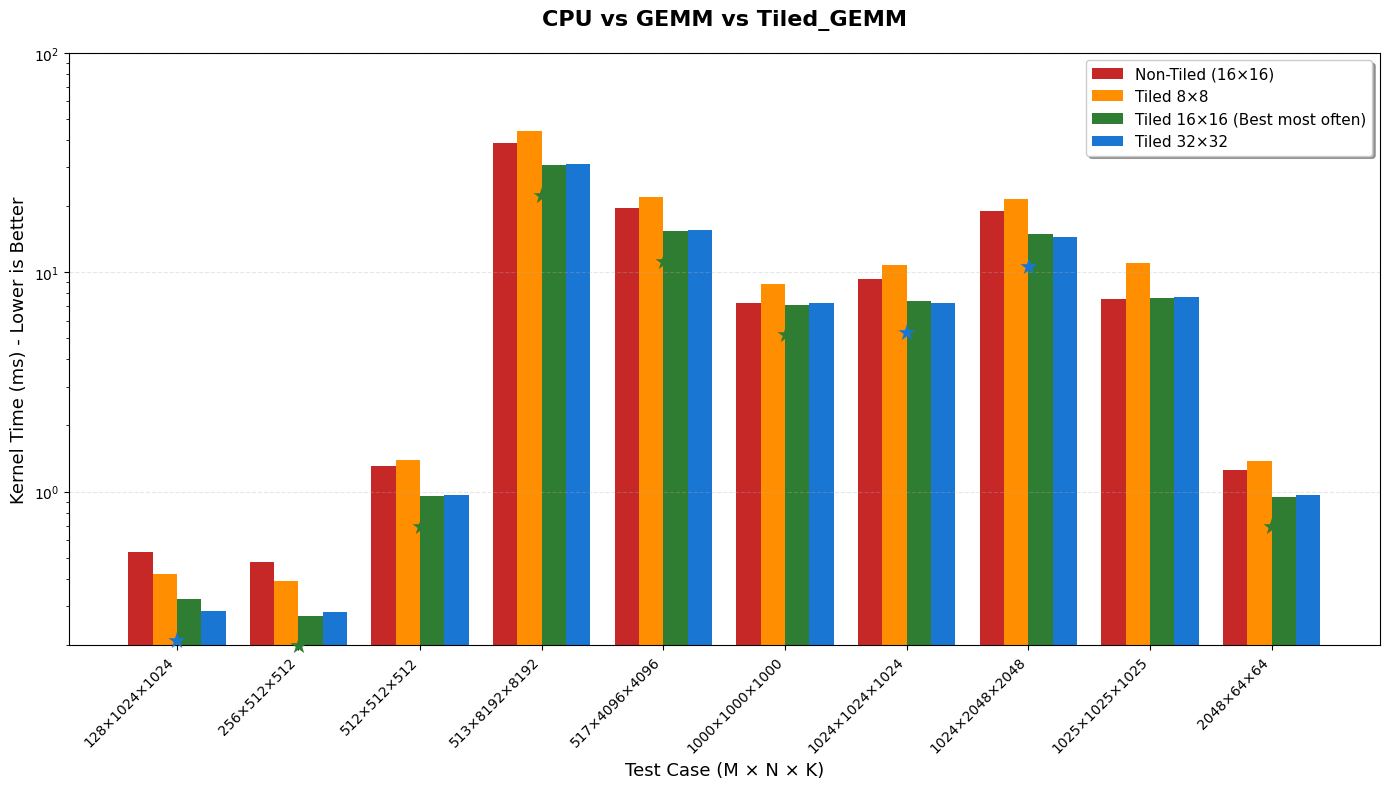

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from your runs (in milliseconds)
cases = [
    "128×1024×1024", "256×512×512", "512×512×512", "513×8192×8192",
    "517×4096×4096", "1000×1000×1000", "1024×1024×1024", "1024×2048×2048",
    "1025×1025×1025", "2048×64×64"
]

non_tiled = [0.531, 0.479, 1.304, 38.869, 19.654, 7.234, 9.307, 18.985, 7.533, 1.250]
tiled_8x8  = [0.422, 0.389, 1.393, 43.913, 21.950, 8.798, 10.738, 21.539, 11.051, 1.380]
tiled_16x16= [0.323, 0.272, 0.950, 30.737, 15.372, 7.084, 7.401, 14.871, 7.633, 0.949]
tiled_32x32= [0.285, 0.281, 0.967, 31.182, 15.611, 7.214, 7.245, 14.486, 7.725, 0.965]

# Convert to numpy for easy handling
x = np.arange(len(cases))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.bar(x - 1.5*width, non_tiled,   width, label='Non-Tiled (16×16)',      color='#c62828')
bars2 = ax.bar(x - 0.5*width, tiled_8x8,   width, label='Tiled 8×8',               color='#ff8f00')
bars3 = ax.bar(x + 0.5*width, tiled_16x16, width, label='Tiled 16×16 (Best most often)', color='#2e7d32')
bars4 = ax.bar(x + 1.5*width, tiled_32x32, width, label='Tiled 32×32',              color='#1976d2')

ax.set_xlabel('Test Case (M × N × K)', fontsize=13)
ax.set_ylabel('Kernel Time (ms) - Lower is Better', fontsize=13)
ax.set_title('CPU vs GEMM vs Tiled_GEMM', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(cases, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11, fancybox=True, shadow=True)

# Log scale because large cases dominate
ax.set_yscale('log')
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0.2, 100)

# Annotate the best performer in each group
for i, (t16, t32) in enumerate(zip(tiled_16x16, tiled_32x32)):
    best = min(t16, t32, non_tiled[i], tiled_8x8[i])
    if best == t16:
        ax.text(i, t16 * 0.8, '★', ha='center', va='top', fontsize=16, fontweight='bold', color='#2e7d32')
    elif best == t32:
        ax.text(i, t32 * 0.8, '★', ha='center', va='top', fontsize=16, fontweight='bold', color='#1976d2')

plt.tight_layout()
plt.show()